In [ ]:
#library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from xgboost import XGBClassifier

import shap
#Load Data
credit_df = pd.read_csv('../data/credit_scoring.csv')

<h1> EDA <h1>

In [131]:
credit_df.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020


In [132]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [133]:
credit_df.describe()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
count,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,503999.500000,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167,0.012167,0.011945
std,1732.195139,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639,0.109639,0.113947
min,501000.000000,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000,0.000000,-0.119000
25%,502499.750000,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000,0.000000,-0.020000
50%,503999.500000,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000,0.000000,0.000000
75%,505499.250000,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000,0.000000,0.021000
max,506999.000000,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000,1.000000,1.092000


In [134]:
credit_df.isna().sum()

,0
application_id,0
age,0
monthly_income,0
loan_amount,0
previous_defaults,0
credit_score,0
default,0
leak_col_good,0
leak_col_subtle,0


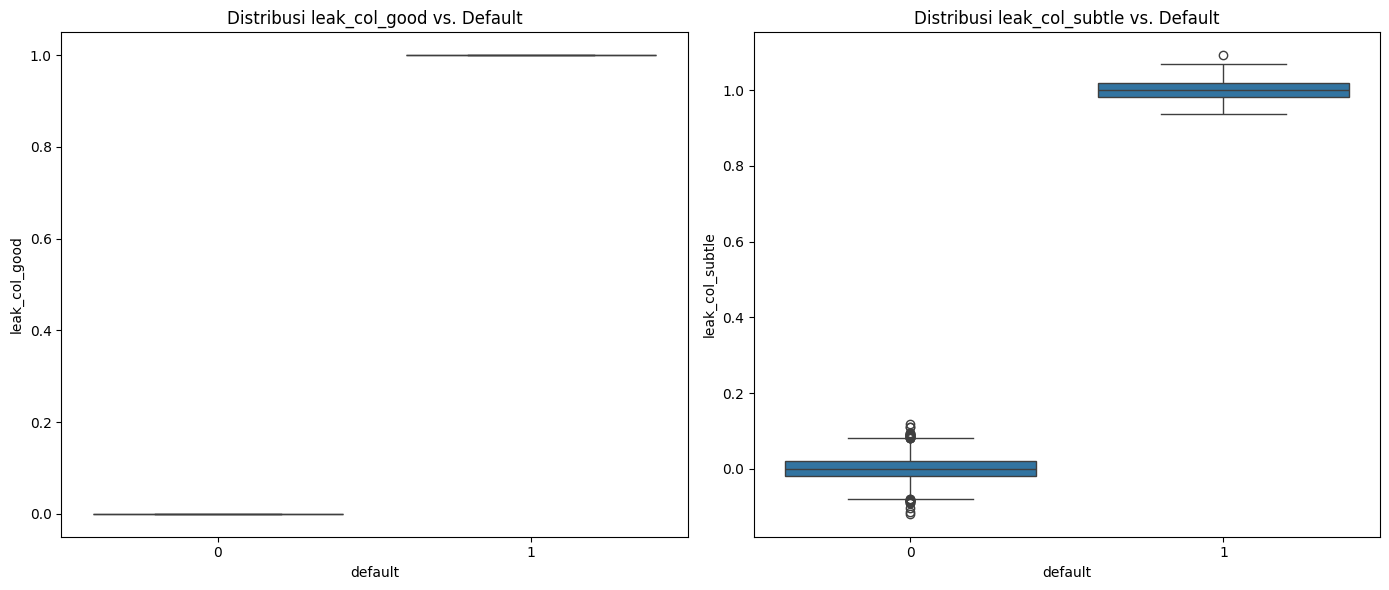

In [135]:
#Melihat kebocoran data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Boxplot leak_col_good
sns.boxplot(ax=axes[0], x='default', y='leak_col_good', data=credit_df)
axes[0].set_title('Distribusi leak_col_good vs. Default')
# Boxplot leak_col_subtle
sns.boxplot(ax=axes[1], x='default', y='leak_col_subtle', data=credit_df)
axes[1].set_title('Distribusi leak_col_subtle vs. Default')
plt.tight_layout()
plt.show()

<h1>Preprocessing<h1>

In [136]:
#Drop Data Leakage dan fitur yg tidak relevan (id)

credit_df_cleaned = credit_df.drop(columns=['leak_col_good', 'leak_col_subtle', 'application_id'])

In [137]:
credit_df_cleaned

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,41,13995609,5982664,0,624,0
1,58,13683833,3711198,0,809,0
2,33,9417391,7172332,0,647,0
3,45,6861811,8661056,0,450,0
4,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...
5995,26,18253018,3690565,2,729,0
5996,40,9944385,4082038,1,477,0
5997,28,9048532,14760384,0,450,0
5998,51,6843160,11774594,0,561,0


<h1>Modelling with Logistic Regression (Baseline)<h1>


In [138]:
#Pilih fitur dan Split data
X = credit_df_cleaned.drop(columns=['default'])
y = credit_df_cleaned['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [139]:
#Logistic Regression
log_regression= LogisticRegression(random_state=42, max_iter=1000)
log_regression.fit(X_train, y_train)
y_pred = log_regression.predict(X_test)

# Evaluasi hasil
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



[[1185    0]
 [  15    0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.98      0.99      0.98      1200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [140]:
y_proba = log_regression.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc:.4f}")

ROC AUC Score: 0.6959


Menggunakan Logistic Regression model memberikan hasil score auc 0.69, dan jika dilihat dari confusion matrix, model hanya memprediksi benar pada kelas 0, hal ini dapat terjadi karena distribusi data kelas 0 dan 1 yang tidak seimbang (Imbalance Class)

<h1> Modelling Gradient Boosting <h1>

In [141]:



grad_boost = GradientBoostingClassifier(random_state=42)
grad_boost.fit(X_train, y_train)

y_pred_gb = grad_boost.predict(X_test)
y_pred_proba_gb = grad_boost.predict_proba(X_test)[:, 1]


print(confusion_matrix(y_test, y_pred_gb))

print(classification_report(y_test, y_pred_gb))

auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
print(f"\nSkor AUC Gradient Boosting: {auc_gb:.4f}")

[[1183    2]
 [  15    0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.98      0.99      0.98      1200


Skor AUC Gradient Boosting: 0.6863


Karena model belum menunjukan skor auc yg bagus (hampir sama seperti model logistic regression) dan belum dapat mendeteksi kelas default 1 yg disebabkan oleh imbalance data, maka selanjutnya akan dilakukan proses penanganan terhadap imbalance data

<h1>Menangani Imbalance dengan SMOTE

In [142]:
pip install imbalanced-learn

In [143]:
from imblearn.over_sampling import SMOTE

# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:", y_train.value_counts().to_dict())
print("Setelah SMOTE:", pd.Series(y_resampled).value_counts().to_dict())


Sebelum SMOTE: {0: 4742, 1: 58}
Setelah SMOTE: {0: 4742, 1: 4742}


In [144]:
from sklearn.ensemble import GradientBoostingClassifier

model_smote = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model_smote.fit(X_resampled, y_resampled)


GradientBoostingClassifier(random_state=42)

In [145]:
y_pred = model_smote.predict(X_test)
y_proba = model_smote.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1185
           1       0.02      0.20      0.03        15

    accuracy                           0.83      1200
   macro avg       0.50      0.52      0.47      1200
weighted avg       0.98      0.83      0.90      1200

AUC Score: 0.5605907172995781


Setelah penanganan imbalance class dilakukan, terjadi penurunan score auc di 0.56 yang berarti model masih buruk dalam memprediksi. hal ini  dapat disebabkan oleh fitur tidak cukup kuat untuk prediksi. dan karena ditambah data sintetis bisa saja fiturnya tidak representatif

Akan dicoba menggunakan XGBoost dan scale post weight

<h1>Modelling with XGBoost and Scale post weight <h1>

In [146]:
!pip install xgboost


In [147]:
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight: {scale:.2f}")

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=scale,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)


xgb_model.fit(X_train, y_train)


scale_pos_weight: 81.76


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [148]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print("AUC Score:", roc_auc_score(y_test, y_proba_xgb))


              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1185
           1       0.02      0.13      0.04        15

    accuracy                           0.92      1200
   macro avg       0.51      0.53      0.50      1200
weighted avg       0.98      0.92      0.95      1200

AUC Score: 0.6390154711673698


Dilihat dari skor f1, recall, dan precision serta akurasinya model ini memberikan hasil yang lebih baik dari model yang lainnya, walaupun nilai auc scorenya masih < 0.7.

<h1>Kesimpulan<h1>

Setelah percobaan dengan 4 model yaitu
<br>
1.Logistic Regression<br>
1.Gradient Boosting<br>
3.Gradient Boosting dengan SMOTE<br>
4.XGBoost dengan Scale Post Weight
<br>
Hasilnya, Logistic Regression memberikan auc score 0.69 namun tidak dapat memprediksi kelas default , Gradient Boosting juga memberikan hasil yang tidak jauh berbeda, kemudian dilakukan penanganan imbalance kelas dengan SMOTE, model dapat memprediksi kelas default namun score aucnya lebih rendah dibanding yg lain yaitu 0.56 dan model xgboost yang menggunakan scale post weight menghasilkan score 0.64 dan akurasi yang baik yaitu 0.92 dan lebih bisa memprediksi kelas deault .<br>
Sehingga model akhir yang dipilih adalah XGBoost dengan scale post weight namun masih perlu penguatan fitur atau data tambahan untuk meningkatkan AUC di atas 0.7





<h1>FUNGSI SCORECARD

In [149]:
def convert_to_credit_score(proba, min_score=300, max_score=850):
    return max_score - (proba * (max_score - min_score))


In [150]:
result_df['credit_score'] = convert_to_credit_score(y_proba_xgb)


In [151]:
result_df

,age,monthly_income,loan_amount,previous_defaults,credit_score,true_default,default_proba
730,24,5410762,2006571,0,845.132935,0,0.036785
4541,54,8778441,14120345,0,593.311157,0,0.414389
4065,28,14890214,2779923,0,849.220154,0,0.006113
1030,50,7157863,2182941,0,830.280762,0,0.085089
2346,37,5810685,7980815,0,840.546692,0,0.120945
...,...,...,...,...,...,...,...
516,51,13984242,8223082,1,839.019043,0,0.047339
3335,39,19009353,8497236,0,829.054565,0,0.479099
965,57,3282043,3011847,1,842.184814,0,0.128149
5468,34,12881082,7750416,0,643.016541,0,0.739793


<h1>Analisis SHAP

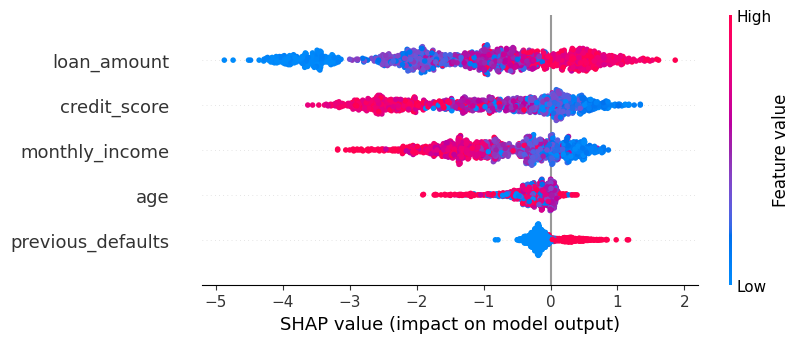

<Figure size 640x480 with 0 Axes>

In [152]:
explainer = shap.Explainer(xgb_model)

shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)
plt.savefig('shap_summary_plot.png', bbox_inches='tight', dpi=150)


Interpretasi Plot:
<br>
Fitur terkuat diurutkan dari atas ke bawah<br>
1. Loan Amount<br>
Jumlah pinjaman yang makin besar, menaikan prediksi resiko gagal bayar
<br>
2. Credit Score<br>
Semakin tinggi credit scorenya maka kemungkinan gagal bayar semakin rendah<br>
3. Monthly Amount<br>
semakin rendah pendapatan bulanannya, semakin tinggi resiko gagal bayar
<br>
4. Age<br>
polanya tidak sekuat 3 fitur sebelumnya
<br>
5. Previous_default<br>
apabila memiliki riwayat gagal bayar sebelumnya, akan menaikan prediksi resiko gagal bayar

<h1> Study Case Pinjaman 5 juta

dengan  contoh profile yang diambil dari Data test baris ke 3

In [153]:
X_test.iloc[3]

,1030
age,50
monthly_income,7157863
loan_amount,2182941
previous_defaults,0
credit_score,425


In [154]:
nasabah = X_test.iloc[3].copy()
nasabah['loan_amount'] = 5000000
import numpy as np
nasabah_reshaped = np.array(nasabah).reshape(1, -1)

proba = xgb_model.predict_proba(nasabah_reshaped)[0][1]
score = convert_to_credit_score(proba)

print(f"Probabilitas default(gagal bayar): {proba:.2%}")
print(f"Skor kredit: {score:.0f}")

Probabilitas default(gagal bayar): 12.59%
Skor kredit: 781
